### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

### Load Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo"]

transform_list = [
    SelectQM9TargetProperties(properties=properties),
    SelectQM9NodeFeatures(features=["atom_type"]),
]
if not include_hydrogen:
    transform_list.append(DropQM9Hydrogen())

max_num_nodes = 29 if include_hydrogen else 9
transform_list += [
    AddAdjacencyMatrix(max_num_nodes=max_num_nodes),
    AddNodeAttributeMatrix(max_num_nodes=max_num_nodes),
    AddEdgeAttributeMatrix(max_num_nodes=max_num_nodes),
]

pre_transform = T.Compose(transform_list)
transform = T.Compose([
    #RandomPermutation(max_num_nodes=max_num_nodes),
    T.ToDevice(device=device)
])

dataset = QM9(root="./data", pre_transform=pre_transform, pre_filter=qm9_pre_filter, transform=transform)

train_dataset, val_dataset, test_dataset = create_qm9_data_split(dataset=dataset)

batch_size = 256
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "full": DataLoader(dataset, batch_size=batch_size, shuffle=False)
}

### Load Models

In [3]:
# load model
graph_vae_model = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240303_201208.pt").to(device=device)
graph_vae_model_prop = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240303_204747.pt").to(device=device)

graph_vae_model.eval()
graph_vae_model_prop.eval()

GraphVAE(
  (encoder): Encoder(
    (ecc_conv_1): ECCConv(4, 32)
    (batch_norm_1): BatchNorm(32)
    (relu_1): PReLU(num_parameters=1)
    (ecc_conv_2): ECCConv(32, 64)
    (batch_norm_2): BatchNorm(64)
    (relu_2): PReLU(num_parameters=1)
    (ecc_conv_3): ECCConv(64, 128)
    (batch_norm_3): BatchNorm(128)
    (relu_3): PReLU(num_parameters=1)
    (graph_pooling): GlobalGraphPooling(
      (fc_i): Linear(in_features=128, out_features=128, bias=True)
      (fc_j): Linear(in_features=128, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (fcls): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5

### Kernel Density Estimate of the Latent Variables

In [4]:
def plot_latent_kde(model: GraphVAE, val_loader: DataLoader):
    """ Plot a kernel density estimate of the distribution of ~5000 encoded validation molecules along each dimension of the latent space. """

    z_list = []
    num_molecules = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            z = model.encode(batch)
        z_list.append(z)
        num_molecules += len(batch)
        if num_molecules > 5000:
            break

    z = torch.concat(z_list, dim=0).detach().cpu()
    print(f"Encoded {num_molecules} molecules.")

    latent_dim = model.latent_dim
    for dim in range(z.shape[1]):
        sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

    plt.title(f'KDE of each latent dimension (n={latent_dim})')
    plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

 37%|███▋      | 19/51 [00:02<00:04,  6.60it/s]


Encoded 5120 molecules.


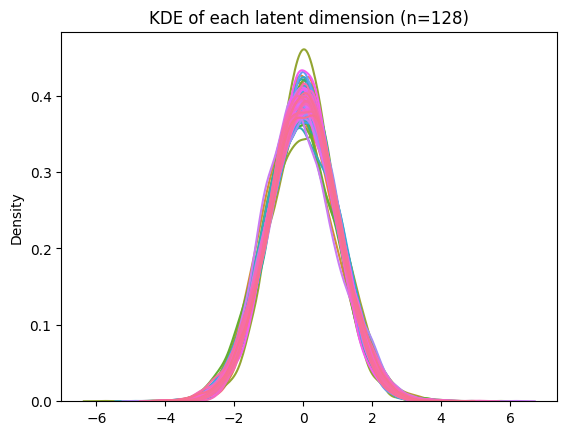

In [5]:
# without property prediction
plot_latent_kde(graph_vae_model, dataloaders["val"])

 37%|███▋      | 19/51 [00:01<00:02, 14.10it/s]


Encoded 5120 molecules.


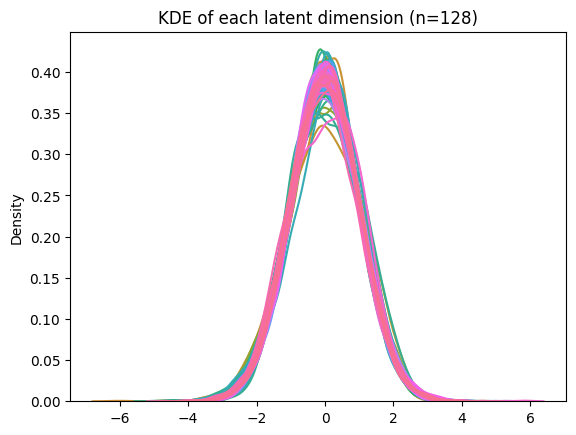

In [8]:
# with property prediction
plot_latent_kde(graph_vae_model_prop, dataloaders["val"])

### Histograms

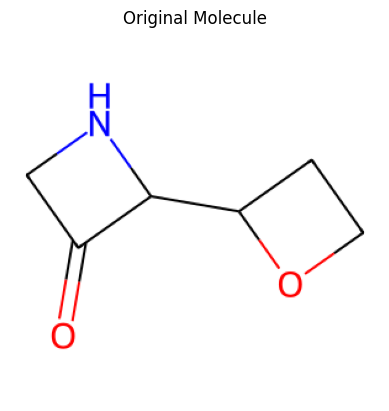

In [6]:
src_mol_graph = val_dataset[8]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.title("Original Molecule")
plt.axis("off")
plt.show()
z = graph_vae_model.encode(src_mol_graph)

Input SMILES: [H]N1C([H])([H])C(=O)[C@]1([H])[C@]1([H])OC([H])([H])C1([H])[H]


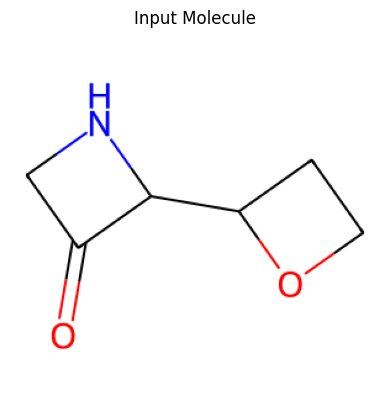

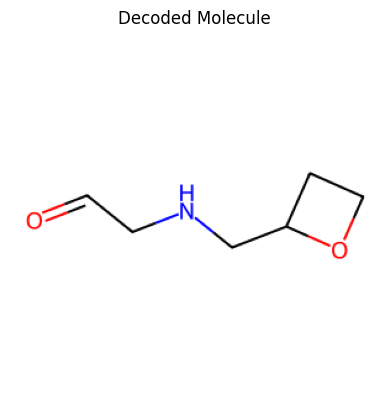

In [64]:
val_loader = dataloaders["val"]

index = 8

with torch.no_grad():
    for val_batch in val_loader:

        print(f"Input SMILES: {val_batch[index].smiles}")

        input_mol = graph_to_mol(data=val_batch[index], includes_h=include_hydrogen, validate=False)
        input_mol_img = mol_to_image_tensor(mol=input_mol).transpose(1, 3).transpose(1, 2)
        plt.imshow(input_mol_img[0])
        plt.title("Input Molecule")
        plt.axis("off")
        plt.show()

        # TODO: encode 100 times and decode determistically
        # TODO: encode once and decode 100 times stochastically
        z = graph_vae_model.encode(val_batch)
        val_recon = graph_vae_model.decode(z[index].unsqueeze(0))
        
        x = (val_recon[0], val_recon[1], val_recon[2])
        recon_graph = graph_vae_model.output_to_graph(x=x, stochastic=False)
        recon_mol = graph_to_mol(data=recon_graph, includes_h=include_hydrogen, validate=False)

        recon_mol_img = mol_to_image_tensor(mol=recon_mol).transpose(1, 3).transpose(1, 2)
        plt.imshow(recon_mol_img[0])
        plt.title("Decoded Molecule")
        plt.axis("off")
        plt.show()

        break

In [31]:
b = next(iter(val_loader))
b

DataBatch(x=[2256, 4], edge_index=[2, 4830], edge_attr=[4830, 4], y=[256, 2], pos=[4625, 3], z=[4625], smiles=[256], name=[256], idx=[256], adj_triu_mat=[256, 45], node_mat=[256, 9, 4], edge_triu_mat=[256, 36, 4], batch=[2256], ptr=[257])

In [ ]:
# TODO: encode a molecule 100 times
# TODO: plot histogram of deterministically decoded molecules

### PCA

In [11]:
import pandas as pd

graph_vae_model.eval()

loader = dataloaders["full"]

z_list = []
props_list = []
for batch in tqdm(loader):
    z = graph_vae_model.encode(batch).detach().cpu()
    z_list.append(z)
    props_list.append(batch.y)

z = torch.concat(z_list)
props = torch.concat(props_list)
prop_df = pd.DataFrame(props.cpu(), columns=properties).reset_index()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


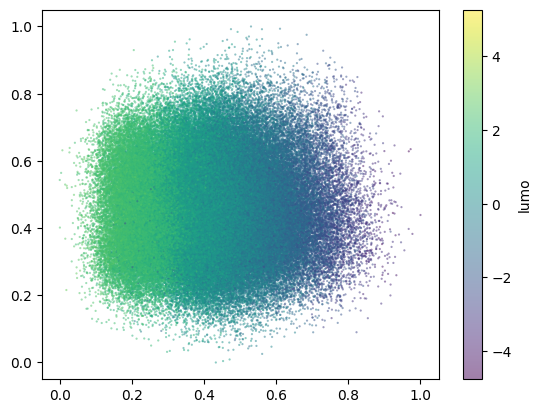

In [12]:
prop_opt = "lumo"

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.colorbar(scatter, label=prop_opt)
plt.show()

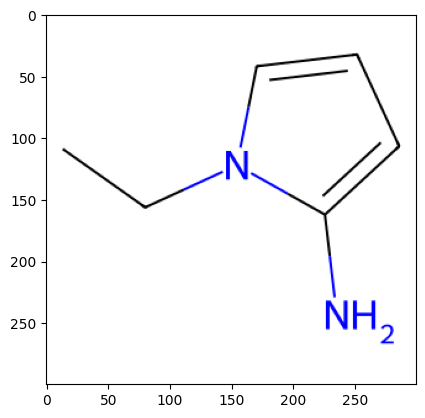

In [134]:
# TODO: get random val set molecule and plot
src_mol_graph = val_dataset[256]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.show()